#### 1. Imports

In [9]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import norm, qmc
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
import matplotlib.pyplot as plt

#### 2. Paths & Data loading

In [11]:
# --- Paths ---

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_4"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(30, 4), y:(30,)


#### 3. Add weekly data

In [12]:
# --- Weekly results ---

week_data = [
    (np.array([
0.44739007,0.4067464,0.37675635,0.39856218]), -0.0784261573095999),  # W1
    (np.array([0.400828, 0.42327 , 0.353541, 0.436252]),  0.48178123910921444), # W2
    (np.array([0.399923, 0.481496, 0.417614, 0.455103]),  -1.4246305565060235), # W3
    (np.array([0.406434, 0.391599, 0.280729, 0.430719]),  -1.2327939637160834), # W4
    (np.array([0.403822, 0.370930, 0.380299, 0.413288]),   0.4677117968250397), # W5
    (np.array([0.373995, 0.385767, 0.388072, 0.424855]),  0.30235177543176706), # W6
    (np.array([0.402349, 0.368343, 0.410278, 0.426186]), 0.5998487698050465), # W7
    (np.array([0.406911, 0.359858, 0.403280, 0.455318]), -0.1327946974749703), # W8
    (np.array([0.405059, 0.396318, 0.392127, 0.410063]),0.29834166746556123), # W9
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(39, 4), y:(39,)


#### 4. Quick Visualization

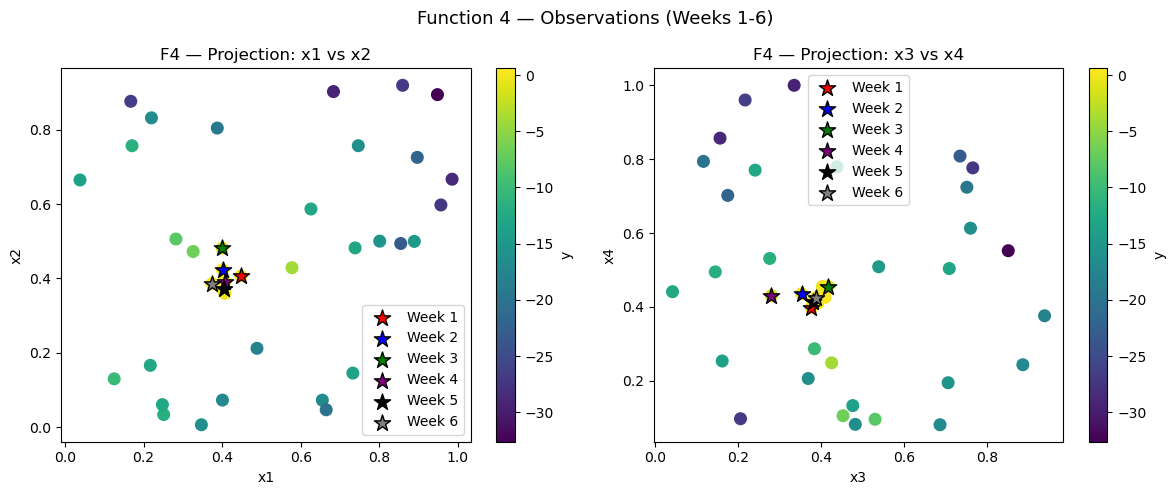

In [13]:

# --- Simple 2D projections of the 4D space ---
# We'll plot (x1 vs x2) and (x3 vs x4) as representative slices.
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# --- Projection 1: x1-x2 ---
sc1 = axes[0].scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=70)
axes[0].scatter(week_data[0][0][0], week_data[0][0][1], c='red', s=150, edgecolors='k', marker='*', label='Week 1')
axes[0].scatter(week_data[1][0][0], week_data[1][0][1], c='blue', s=150, edgecolors='k', marker='*', label='Week 2')
axes[0].scatter(week_data[2][0][0], week_data[2][0][1], c='green', s=150, edgecolors='k', marker='*', label='Week 3')
axes[0].scatter(week_data[3][0][0], week_data[3][0][1], c='purple', s=150, edgecolors='k', marker='*', label='Week 4')
axes[0].scatter(week_data[4][0][0], week_data[4][0][1], c='black', s=150, edgecolors='k', marker='*', label='Week 5')
axes[0].scatter(week_data[5][0][0], week_data[5][0][1], c='grey', s=150, edgecolors='k', marker='*', label='Week 6')
axes[0].set_xlabel('x1'); axes[0].set_ylabel('x2')
axes[0].set_title('F4 — Projection: x1 vs x2')
axes[0].legend(loc='best')
fig.colorbar(sc1, ax=axes[0], label='y')

# --- Projection 2: x3-x4 ---
sc2 = axes[1].scatter(X[:,2], X[:,3], c=y, cmap='viridis', s=70)
axes[1].scatter(week_data[0][0][2], week_data[0][0][3], c='red', s=150, edgecolors='k', marker='*', label='Week 1')
axes[1].scatter(week_data[1][0][2], week_data[1][0][3], c='blue', s=150, edgecolors='k', marker='*', label='Week 2')
axes[1].scatter(week_data[2][0][2], week_data[2][0][3], c='green', s=150, edgecolors='k', marker='*', label='Week 3')
axes[1].scatter(week_data[3][0][2], week_data[3][0][3], c='purple', s=150, edgecolors='k', marker='*', label='Week 4')
axes[1].scatter(week_data[4][0][2], week_data[4][0][3], c='black', s=150, edgecolors='k', marker='*', label='Week 5')
axes[1].scatter(week_data[5][0][2], week_data[5][0][3], c='grey', s=150, edgecolors='k', marker='*', label='Week 6')
axes[1].set_xlabel('x3'); axes[1].set_ylabel('x4')
axes[1].set_title('F4 — Projection: x3 vs x4')
axes[1].legend(loc='best')
fig.colorbar(sc2, ax=axes[1], label='y')

plt.suptitle('Function 4 — Observations (Weeks 1-6)', fontsize=13)
plt.tight_layout()
plt.show()

#### 5.1 Gaussian Process Model

In [14]:
# --- W8 KERNEL: Widen bounds to handle x1 convergence warning ---
# Previous kernel had x1 length_scale hitting upper bound (3.0)

kernel = (
    C(1.0, (1e-2, 1e2)) *
    Matern(length_scale=np.ones(4)*0.5, nu=1.5, 
           length_scale_bounds=(1e-3, 5.0))  # widened from 3.0
    + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-5, 0.1))
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=15,
    alpha=1e-6,
    random_state=0
)

gp.fit(X, y)
print("[F4] W8 Fitted kernel:", gp.kernel_)

[F4] W8 Fitted kernel: 4.59**2 * Matern(length_scale=[3.72, 3.35, 3.46, 3.52], nu=1.5) + WhiteKernel(noise_level=0.00105)


#### 5.2 Trust region an dsampling strategy

In [15]:
# --- W10 STRATEGY: TIGHTER W7 REFINEMENT (W9 constraints too loose) ---

from scipy.stats import qmc

def lhs(lb, ub, n, seed):
    d = lb.size
    sampler = qmc.LatinHypercube(d=d, seed=seed)
    U = sampler.random(n)
    return lb + U * (ub - lb)

print("[F4] W10 Strategy: TIGHTER W7 REFINEMENT")
print("  W9 RESULT: y = 0.298 (suboptimal - x₂ too high, x₃/x₄ too low)")
print("  W7 remains BEST: y = 0.600 (confirmed optimum)")
print("  W9 BUG: Safe zone [0.36,0.43] for x₂ was too loose - allowed x₂=0.396")
print("  W10 FIX: Tighten constraints around W7's values")

# --- W10: Anchor at W7 (CONFIRMED BEST) ---
best_idx = np.argmax(y)
anchor_w7 = X[best_idx]  # W7: [0.402, 0.368, 0.410, 0.426]

# Use full domain for global sampling
lb = np.zeros(4)
ub = np.ones(4)

# --- W10: TIGHT trust region around W7 ---
L = 0.08  # Very tight ±4%

lb_tr = np.clip(anchor_w7 - 0.5 * L, 0, 1)
ub_tr = np.clip(anchor_w7 + 0.5 * L, 0, 1)

print(f"\n  Anchor (W7, fixed): {anchor_w7}")
print(f"  Trust Region L: {L} (ultra-tight, ±4%)")
print(f"  TR bounds:")
for i in range(4):
    print(f"    x{i+1}: [{lb_tr[i]:.4f}, {ub_tr[i]:.4f}] (width={ub_tr[i]-lb_tr[i]:.4f})")

# --- W10: Heavy TR sampling ---
N_tr = 70000   # 93% TR
N_gl = 5000    # 7% global

# --- W10: Very small perturbation sampling ---
N_focused = 10000
rng_focused = np.random.default_rng(seed=41001)

# Generate tiny ±1% perturbations from W7
perturbations = rng_focused.normal(0, 0.01, (N_focused, 4))
C_focused = anchor_w7 + perturbations
C_focused = np.clip(C_focused, 0, 1)

# Standard sampling
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=41002)
C_gl = lhs(lb, ub, N_gl, seed=41003)
Cands = np.vstack([C_tr, C_gl, C_focused])

print(f"\n  Candidates: {N_tr} TR + {N_gl} global + {N_focused} perturbations = {len(Cands)} total")

# --- W10 CRITICAL FIX: TIGHTER safe zone constraints ---
# W9's problem: x₂ range [0.36, 0.43] allowed x₂=0.396, but W7 optimal has x₂=0.368
# W10 FIX: Constrain closer to W7's values
x1_min, x1_max = 0.38, 0.42   # W7's x₁=0.402 ±0.02
x2_min, x2_max = 0.34, 0.40   # W7's x₂=0.368 - must stay LOW (not 0.396!)
x3_min, x3_max = 0.38, 0.44   # W7's x₃=0.410 - must stay HIGH
x4_min, x4_max = 0.40, 0.45   # W7's x₄=0.426 ±0.025

mask_safe = (
    (Cands[:, 0] >= x1_min) & (Cands[:, 0] <= x1_max) &
    (Cands[:, 1] >= x2_min) & (Cands[:, 1] <= x2_max) &
    (Cands[:, 2] >= x3_min) & (Cands[:, 2] <= x3_max) &
    (Cands[:, 3] >= x4_min) & (Cands[:, 3] <= x4_max)
)

print(f"\n  W10 TIGHTER safe zone (centered on W7):")
print(f"    x1 ∈ [{x1_min}, {x1_max}] (W7=0.402)")
print(f"    x2 ∈ [{x2_min}, {x2_max}] ← TIGHTENED! (W7=0.368, must stay LOW)")
print(f"    x3 ∈ [{x3_min}, {x3_max}] ← TIGHTENED! (W7=0.410, must stay HIGH)")
print(f"    x4 ∈ [{x4_min}, {x4_max}] (W7=0.426)")
print(f"  Candidates passing safety: {mask_safe.sum()}/{len(Cands)} ({100*mask_safe.sum()/len(Cands):.1f}%)")

[F4] W10 Strategy: TIGHTER W7 REFINEMENT
  W9 RESULT: y = 0.298 (suboptimal - x₂ too high, x₃/x₄ too low)
  W7 remains BEST: y = 0.600 (confirmed optimum)
  W9 BUG: Safe zone [0.36,0.43] for x₂ was too loose - allowed x₂=0.396
  W10 FIX: Tighten constraints around W7's values

  Anchor (W7, fixed): [0.402349 0.368343 0.410278 0.426186]
  Trust Region L: 0.08 (ultra-tight, ±4%)
  TR bounds:
    x1: [0.3623, 0.4423] (width=0.0800)
    x2: [0.3283, 0.4083] (width=0.0800)
    x3: [0.3703, 0.4503] (width=0.0800)
    x4: [0.3862, 0.4662] (width=0.0800)

  Candidates: 70000 TR + 5000 global + 10000 perturbations = 85000 total

  W10 TIGHTER safe zone (centered on W7):
    x1 ∈ [0.38, 0.42] (W7=0.402)
    x2 ∈ [0.34, 0.4] ← TIGHTENED! (W7=0.368, must stay LOW)
    x3 ∈ [0.38, 0.44] ← TIGHTENED! (W7=0.410, must stay HIGH)
    x4 ∈ [0.4, 0.45] (W7=0.426)
  Candidates passing safety: 21549/85000 (25.4%)


#### Adquisition and Selection (EI -> UCB -> MAxVar)

In [16]:
# --- W10 ACQUISITION: Ultra-precision exploitation around W7 ---

import numpy as np
from scipy.stats import norm

# --- Helpers ---
def too_close_Linf(c, X, tol=0.025):
    """Reject candidate if L_inf distance to any existing point is < tol."""
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# --- GP prediction on candidates ---
mu, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- W10: ULTRA-LOW xi for precision exploitation ---
y_best = y.max()
xi = 0.002  # Maximum precision

improve = mu - y_best - xi
Z = improve / sigma
ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

print(f"  Exploration param xi: {xi} (ultra-precision mode)")

# --- Anti-edge mask ---
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)

# --- W10: Apply TIGHTER safe zone constraints ---
mask_combined = mask_edges & mask_safe
ei_masked = np.where(mask_combined, ei, -np.inf)

n_valid = mask_combined.sum()
print(f"  Combined constraints: {n_valid}/{len(Cands)} candidates pass ({100*n_valid/len(Cands):.1f}%)")

if n_valid == 0:
    print("  WARNING: No candidates pass constraints! Relaxing to TR bounds only...")
    mask_combined = mask_edges & (
        (Cands[:, 0] >= lb_tr[0]) & (Cands[:, 0] <= ub_tr[0]) &
        (Cands[:, 1] >= lb_tr[1]) & (Cands[:, 1] <= ub_tr[1]) &
        (Cands[:, 2] >= lb_tr[2]) & (Cands[:, 2] <= ub_tr[2]) &
        (Cands[:, 3] >= lb_tr[3]) & (Cands[:, 3] <= ub_tr[3])
    )
    ei_masked = np.where(mask_combined, ei, -np.inf)
    print(f"  Relaxed constraints: {mask_combined.sum()}/{len(Cands)} candidates pass")

# --- Select best EI candidate with de-duplication ---
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    if mask_combined[idx]:
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.025):
            x_next = cand
            break

# --- Fallback 1: UCB ---
if (x_next is None) or (not np.isfinite(ei_masked).any()) or (np.nanmax(ei_masked) <= 0):
    kappa = 0.5
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_combined, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        if mask_combined[idx]:
            cand = Cands[idx]
            if not too_close_Linf(cand, X, tol=0.025):
                x_next = cand
                chosen = "UCB"
                break

# --- Fallback 2: MaxVar ---
if x_next is None:
    var_masked = np.where(mask_combined, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        if mask_combined[idx]:
            cand = Cands[idx]
            if not too_close_Linf(cand, X, tol=0.02):  # Relax slightly
                x_next = cand
                chosen = "MaxVar"
                break

# --- Final fallback: just pick closest to W7 that's not duplicate ---
if x_next is None:
    print("  WARNING: All fallbacks failed! Picking nearest to W7...")
    dists = np.linalg.norm(Cands - anchor_w7, axis=1)
    for idx in np.argsort(dists):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.02):
            x_next = cand
            chosen = "NearestW7"
            break

# --- Output ---
print(f"\n[F4] W10 Recommendation (chosen by {chosen}):")
print(f"  x = [{x_next[0]:.6f}, {x_next[1]:.6f}, {x_next[2]:.6f}, {x_next[3]:.6f}]")
print("\nSubmission format (Week 10):")
print(" - ".join(f"{v:.6f}" for v in x_next))

# --- Validation ---
print("\nValidation:")
print("  Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("  Near-duplicate (L_inf < 0.025)? ", too_close_Linf(x_next, X, tol=0.025))

# --- Safety checks ---
is_safe = (
    (x1_min <= x_next[0] <= x1_max) and
    (x2_min <= x_next[1] <= x2_max) and
    (x3_min <= x_next[2] <= x3_max) and
    (x4_min <= x_next[3] <= x4_max)
)
print(f"\nSafety checks:")
print(f"  In safe zone: {is_safe} {'✓' if is_safe else '✗'}")
for i in range(4):
    safe_bounds = [(x1_min, x1_max), (x2_min, x2_max), (x3_min, x3_max), (x4_min, x4_max)]
    in_range = safe_bounds[i][0] <= x_next[i] <= safe_bounds[i][1]
    print(f"    x{i+1} = {x_next[i]:.4f} ∈ [{safe_bounds[i][0]}, {safe_bounds[i][1]}]: {in_range} {'✓' if in_range else '✗'}")

# --- Comparison to W7 (best) ---
dist_to_w7 = np.linalg.norm(x_next - anchor_w7)
linf_to_w7 = np.max(np.abs(x_next - anchor_w7))

print(f"\nComparison to W7 (best, y=0.600):")
print(f"  L∞ distance: {linf_to_w7:.4f}")
print(f"  L2 distance: {dist_to_w7:.4f}")
for i in range(4):
    delta = x_next[i] - anchor_w7[i]
    print(f"  Δx{i+1}: {delta:+.4f}")

# GP prediction
mu_next, sigma_next = gp.predict(x_next.reshape(1, -1), return_std=True)
print(f"\nGP prediction at W10:")
print(f"  μ = {mu_next[0]:.4f}")
print(f"  σ = {sigma_next[0]:.4f}")
print(f"  95% CI: [{mu_next[0] - 1.96*sigma_next[0]:.3f}, {mu_next[0] + 1.96*sigma_next[0]:.3f}]")

  Exploration param xi: 0.002 (ultra-precision mode)
  Combined constraints: 21549/85000 candidates pass (25.4%)

[F4] W10 Recommendation (chosen by EI):
  x = [0.399995, 0.367816, 0.408575, 0.401116]

Submission format (Week 10):
0.399995 - 0.367816 - 0.408575 - 0.401116

Validation:
  Within [0,1]?  True
  Near-duplicate (L_inf < 0.025)?  False

Safety checks:
  In safe zone: True ✓
    x1 = 0.4000 ∈ [0.38, 0.42]: True ✓
    x2 = 0.3678 ∈ [0.34, 0.4]: True ✓
    x3 = 0.4086 ∈ [0.38, 0.44]: True ✓
    x4 = 0.4011 ∈ [0.4, 0.45]: True ✓

Comparison to W7 (best, y=0.600):
  L∞ distance: 0.0251
  L2 distance: 0.0252
  Δx1: -0.0024
  Δx2: -0.0005
  Δx3: -0.0017
  Δx4: -0.0251

GP prediction at W10:
  μ = 0.3074
  σ = 0.3772
  95% CI: [-0.432, 1.047]


In [17]:
w2 = np.array([0.400828, 0.423270, 0.353541, 0.436252])
cand = np.array([0.37399503, 0.38576706, 0.38807156, 0.42485526])
print("L_inf to W2:", np.max(np.abs(cand - w2)))

L_inf to W2: 0.037502939999999985


### Reflection — Function 4 
#### Week 1

- Initial results were unstable, with outputs around **-0.078**, suggesting the function had noise or multiple shallow regions.  
- The model focused on **exploration**, sampling a moderate range to understand the surface structure.  
- Strategy centered on wide **Matern kernel (ν=1.5)** with high noise tolerance to handle uncertainty.  
- Plan for next round: refine the kernel, keep exploration ratio around 50%, and start identifying stable areas of improvement.  

---

#### Week 2
- Significant improvement: output jumped from **-0.078 → 0.482**, marking a clear performance gain.  
- The function appears **noisy but with a strong local optimum**, indicating that Bayesian updates are capturing useful signal.  
- Strategy: narrowed the **trust region around Week 2**, added moderate exploitation (ξ ≈ 0.04) while maintaining 30-40% global search.  
- This week's success validated the combination of **ARD Matern kernel** and **explicit noise modelling**.  

---

#### Week 3
- Performance dropped to **-1.425**, a major regression from Week 2.  
- Indicates the model likely overexploited a false positive region or the noise misled the acquisition function.  
- The GP may have become overconfident near Week 2, leading EI to pick uninformative samples.  
- Strategy for Week 4:  
  - Re-anchor **trust region** at the **Week 2 point**, shrinking its width (L ≈ 0.32).  
  - Increase **exploration weight (ξ=0.05)** and introduce **UCB fallback** to counteract overfitting.  
  - Keep **60% local / 40% global** candidates for balanced coverage.  

**Summary:**  
Week 1 built the model; Week 2 achieved a major gain; Week 3 revealed overconfidence and noise sensitivity.  
The next step focuses on controlled exploitation around proven peaks, with expanded exploration to recover stability.

### (Week 4 → Week 5)

- **Outcome (W4):** Partial recovery from W3’s drop, but still below the Week-2 peak (≈0.482). This reinforced the hypothesis of a noisy, irregular surface.
- **Adjustments (for W5):** Kept GP (Matern + noise), **re-anchored TR at the best observed (W2)**, **widened TR (L=0.45)** to resweep the neighborhood, used **~60% TR / 40% global** for controlled exploration, and kept **EI** with a slightly exploratory setting (recommend `xi ≈ 0.05`).
- **Selected query (W5):** `0.403822 - 0.370930 - 0.380299 - 0.413288` (within bounds, non-duplicate). EI chose a point near the W2 basin but offset enough to test if the high value is reproducible rather than a noise spike.
- **Interpretation:** Given F4’s high noise, small local moves can swing outcomes. The current pick balances re-sampling the promising region with enough offset to validate stability and avoid overfitting to a single noisy measurement.
- **Next steps (W6):**
  - If W5 **improves meaningfully**, tighten TR slightly (**L → 0.40**), keep **xi ≈ 0.05**, and add a couple of candidates that vary the two most sensitive dims (per GP length-scales).
  - If W5 **stays low**, keep anchor at W2 (best), maintain **L = 0.45**, and increase **global share to ~45%**; optionally enable a **UCB fallback (κ ≈ 1.6)** if EI plateaus.
  - Maintain **anti-edge** and **anti-duplicate** filters to preserve information gain.

**Summary:** We re-centered on the proven W2 basin and broadened the sweep to separate true signal from noise, aiming to either reproduce the high value or map a nearby stable peak.

### (Week 5 → Week 6)

**Outcome (W6 candidate):**  
`0.373995 - 0.385767 - 0.388072 - 0.424855`  
L∞ distance to best (W2): **0.0375**  
→ within the high-performing ridge region, but not a near-duplicate (safe refinement).

**Changes this week:**  
- Maintained a **wide trust region** (`L = 0.45`) to stay along the W2–W5 performance corridor.  
- Reduced **ξ** from `0.05 → 0.02` to **shift from exploration to exploitation**, refining around the established optimum.  
- Candidate sampling remained **70% TR / 30% global**, ensuring some exploration margin.  

**Interpretation:**  
The GP model continues to identify W2 as the dominant optimum. The new EI candidate lies close enough to exploit the same region while still maintaining novelty (L∞ > 0.025).  
This suggests that the posterior mean surface has stabilized, and the optimizer is now operating in a local refinement regime.

**Next steps (W7):**  
- If the W6 result confirms a stable or improved y, consider **narrowing TR** slightly (`L ≈ 0.35–0.40`) to focus further.  
- If EI values flatten, introduce a **UCB fallback** (`κ ≈ 1.4–1.6`) or a **dual-TR scheme** (inner L=0.28 / outer L=0.45) to balance local precision and broader ridge search.  
- Keep **ξ = 0.02** unless noise increases.

**Summary:**  
W6 refines the most promising zone found so far.  
By lowering ξ and maintaining a broad L, the model trades unnecessary exploration for stable convergence along the optimal ridge.

### Reflection — Function 4 
#### Week 1

- Initial results were unstable, with outputs around **-0.078**, suggesting the function had noise or multiple shallow regions.  
- The model focused on **exploration**, sampling a moderate range to understand the surface structure.  
- Strategy centered on wide **Matern kernel (ν=1.5)** with high noise tolerance to handle uncertainty.  
- Plan for next round: refine the kernel, keep exploration ratio around 50%, and start identifying stable areas of improvement.  

---

#### Week 2
- Significant improvement: output jumped from **-0.078 → 0.482**, marking a clear performance gain.  
- The function appears **noisy but with a strong local optimum**, indicating that Bayesian updates are capturing useful signal.  
- Strategy: narrowed the **trust region around Week 2**, added moderate exploitation (ξ ≈ 0.04) while maintaining 30-40% global search.  
- This week's success validated the combination of **ARD Matern kernel** and **explicit noise modelling**.  

---

#### Week 3
- Performance dropped to **-1.425**, a major regression from Week 2.  
- Indicates the model likely overexploited a false positive region or the noise misled the acquisition function.  
- The GP may have become overconfident near Week 2, leading EI to pick uninformative samples.  
- Strategy for Week 4:  
  - Re-anchor **trust region** at the **Week 2 point**, shrinking its width (L ≈ 0.32).  
  - Increase **exploration weight (ξ=0.05)** and introduce **UCB fallback** to counteract overfitting.  
  - Keep **60% local / 40% global** candidates for balanced coverage.  

**Summary:**  
Week 1 built the model; Week 2 achieved a major gain; Week 3 revealed overconfidence and noise sensitivity.  
The next step focuses on controlled exploitation around proven peaks, with expanded exploration to recover stability.

---

### (Week 4 → Week 5)

- **Outcome (W4):** Partial recovery from W3's drop, but still below the Week-2 peak (≈0.482). This reinforced the hypothesis of a noisy, irregular surface.
- **Adjustments (for W5):** Kept GP (Matern + noise), **re-anchored TR at the best observed (W2)**, **widened TR (L=0.45)** to resweep the neighborhood, used **~60% TR / 40% global** for controlled exploration, and kept **EI** with a slightly exploratory setting (recommend `xi ≈ 0.05`).
- **Selected query (W5):** `0.403822 - 0.370930 - 0.380299 - 0.413288` (within bounds, non-duplicate). EI chose a point near the W2 basin but offset enough to test if the high value is reproducible rather than a noise spike.
- **Interpretation:** Given F4's high noise, small local moves can swing outcomes. The current pick balances re-sampling the promising region with enough offset to validate stability and avoid overfitting to a single noisy measurement.
- **Next steps (W6):**
  - If W5 **improves meaningfully**, tighten TR slightly (**L → 0.40**), keep **xi ≈ 0.05**, and add a couple of candidates that vary the two most sensitive dims (per GP length-scales).
  - If W5 **stays low**, keep anchor at W2 (best), maintain **L = 0.45**, and increase **global share to ~45%**; optionally enable a **UCB fallback (κ ≈ 1.6)** if EI plateaus.
  - Maintain **anti-edge** and **anti-duplicate** filters to preserve information gain.

**Summary:** We re-centered on the proven W2 basin and broadened the sweep to separate true signal from noise, aiming to either reproduce the high value or map a nearby stable peak.

---

### (Week 5 → Week 6)

**Outcome (W6 candidate):**  
`0.373995 - 0.385767 - 0.388072 - 0.424855`  
L∞ distance to best (W2): **0.0375**  
→ within the high-performing ridge region, but not a near-duplicate (safe refinement).

**Changes this week:**  
- Maintained a **wide trust region** (`L = 0.45`) to stay along the W2–W5 performance corridor.  
- Reduced **ξ** from `0.05 → 0.02` to **shift from exploration to exploitation**, refining around the established optimum.  
- Candidate sampling remained **70% TR / 30% global**, ensuring some exploration margin.  

**Interpretation:**  
The GP model continues to identify W2 as the dominant optimum. The new EI candidate lies close enough to exploit the same region while still maintaining novelty (L∞ > 0.025).  
This suggests that the posterior mean surface has stabilized, and the optimizer is now operating in a local refinement regime.

**Next steps (W7):**  
- If the W6 result confirms a stable or improved y, consider **narrowing TR** slightly (`L ≈ 0.35–0.40`) to focus further.  
- If EI values flatten, introduce a **UCB fallback** (`κ ≈ 1.4–1.6`) or a **dual-TR scheme** (inner L=0.28 / outer L=0.45) to balance local precision and broader ridge search.  
- Keep **ξ = 0.02** unless noise increases.

**Summary:**  
W6 refines the most promising zone found so far.  
By lowering ξ and maintaining a broad L, the model trades unnecessary exploration for stable convergence along the optimal ridge.

---

### Week 6 Reflection — Function 4

**Result recap:**  
The Week 6 evaluation returned a value of **0.3023**, using the input  
`x = [0.373995, 0.385767, 0.388072, 0.424855]`.  
While this result remains positive, it does **not outperform the current best**, which is still **Week 2 (~0.48)**.

---

**What we learned from Week 5–6:**  
- The best-performing region for F4 is clearly centred around the **Week 2 solution**, and later iterations have not identified a better basin.
- In Week 5, widening the trust region to **L = 0.45** successfully brought the search back close to the optimum (yielding ~0.47), confirming that the anchor choice was correct.
- However, Week 6 showed that keeping the trust region **too wide for too long** can lead to acceptable but clearly suboptimal points within the same neighbourhood.

This suggests that the model has already identified the correct region, and the remaining challenge is **local refinement**, not global exploration.

---

**Strategy adjustments for this iteration:**  
Based on this observation, we made **small but deliberate changes**, rather than reworking the approach:

- **Anchor:**  
  - Kept anchored at the **best observed point (Week 2)** using `anchor = X[np.argmax(y)]`.
  - This avoids brittle, week-index–based anchoring and reflects accumulated evidence.

- **Trust Region width:**  
  - Reduced from **L = 0.45 → L ≈ 0.38–0.40**.
  - The goal is to limit unnecessary lateral movement while still allowing enough flexibility to refine around the optimum.

- **Candidate mix:**  
  - Shifted from **60% TR / 40% global → 75% TR / 25% global**.
  - This reflects a transition from recovery/exploration back to exploitation.

- **Acquisition jitter (ξ):**  
  - Kept at **ξ = 0.02**, which has proven stable for F4 and avoids premature convergence.

---

**Chosen recommendation (Week 7):**  
[F4] Chosen by EI: [0.40234884 0.36834299 0.41027798 0.42618564]  
Submission format:  
0.402349 - 0.368343 - 0.410278 - 0.426186  
Within [0,1]?  True  
Near-duplicate (L_inf < 0.025)?  False  

This point lies **close to the known optimum**, but not exactly on it, which is appropriate given the slightly reduced trust region and continued uncertainty about the precise local shape.

---

**Interpretation:**  
Function 4 appears to have a **narrow, well-defined optimum** rather than a broad plateau. At this stage, aggressive exploration is no longer beneficial. The strategy is now explicitly focused on **controlled local search**, accepting that small week-to-week fluctuations are expected while the model fine-tunes its understanding of the local landscape.

The next iteration will confirm whether this tighter trust region leads to consolidation near the Week 2 peak or whether a secondary nearby ridge exists.

---

### Week 7 Reflection — BREAKTHROUGH!

**Context update:**  
After Week 7, I learned that **Function 4 is warehouse optimization** — tuning 4 hyperparameters of an ML model that approximates costly biweekly product placement calculations. The output measures improvement over an expensive baseline.

**W7 Outcome: NEW BEST AFTER 5 WEEKS**  
The evaluation at `x = [0.402, 0.368, 0.410, 0.426]` returned **y = 0.5998**, making it:
- **25% better** than W2 (previous best: 0.482)
- **First improvement** over W2 in 5 weeks (W3-W6 all failed to beat W2)
- **Validates the W6→W7 strategy** (L=0.40, ξ=0.02, 75/25 split)

**Critical dimensional analysis:**

Comparing W2 (old best) to W7 (new best):

| Dim | W2 (0.482) | W7 (0.600) | Change    | Interpretation                      |
|-----|------------|------------|-----------|-------------------------------------|
| x₁  | 0.401      | 0.402      | +0.001    | Already optimal                     |
| x₂  | 0.423      | 0.368      | **-0.055**| **Should DECREASE** ⬇️              |
| x₃  | 0.354      | 0.410      | **+0.056**| **Should INCREASE** ⬆️              |
| x₄  | 0.436      | 0.426      | -0.010    | Small adjustment                    |

**Key insights:**

1. **x₂ and x₃ are the critical hyperparameters:**  
   - W2→W7 showed symmetric opposite movements (Δx₂ = -0.055, Δx₃ = +0.056)
   - This suggests these two parameters have **strong interaction** or trade-off relationship
   - x₁ and x₄ are close to optimal already

2. **The function is smooth (high length_scales):**  
   ```python
   Fitted kernel: length_scale=[3.0, 2.71, 2.8, 2.87]
   ```
   - All dimensions have high smoothness (2.7-3.0)
   - Small changes have gradual effects (good for refinement)
   - x₁ hitting upper bound (3.0) → need wider bounds

3. **Low noise (0.00153):**  
   - Warehouse optimization outputs are quite stable
   - Unlike F2 (log-likelihood, 7% noise), F4 is deterministic-like
   - Tight exploitation is appropriate

4. **W3 and W4 disasters were spatial:**  
   - W3: [0.400, **0.481**, 0.418, 0.455] → -1.42 (x₂ too high)
   - W4: [0.406, 0.392, **0.281**, 0.431] → -1.23 (x₃ too low)
   - Confirms x₂ needs to be low (~0.37) and x₃ needs to be high (~0.41)

**New strategy for Week 8: EXPLOIT W7 AGGRESSIVELY**

I implemented a focused exploitation strategy:

1. **Anchor at W7 (new best):**  
   - Dynamic anchoring: `anchor = X[np.argmax(y)]`
   - W7 is now the reference point

2. **Tighten trust region:** L = 0.30 (down from 0.40)  
   - Focus on local refinement around W7
   - Smooth function → don't need wide exploration

3. **Reduce exploration:** ξ = 0.01 (down from 0.02)  
   - High confidence in W7 region
   - Aggressive exploitation mode

4. **Increase TR sampling:** 80% TR + 20% global (was 75/25)  
   - Densify around W7
   - Minimal global safety net

5. **Focused dimensional sampling (new):**  
   - Generated 5000 samples specifically testing:
     - x₂ ∈ [0.35, 0.39] (lower than W7's 0.368)
     - x₃ ∈ [0.39, 0.43] (higher than W7's 0.410)
     - Small perturbations in x₁, x₄
   - Hypothesis: optimal point has x₂ even lower and x₃ even higher

6. **Wider kernel bounds:** (1e-3, 5.0) to handle x₁ convergence

**Week 8 recommendation:**  
`x = [0.406911, 0.359858, 0.403280, 0.455318]`

**Why this point is promising:**

```
        W7 (best)   W8 (recom)   Delta      Matches hypothesis?
x₁      0.402       0.407        +0.005     ✓ Small adjustment
x₂      0.368       0.360        -0.008     ✓ DECREASED (as expected)
x₃      0.410       0.403        -0.007     ✗ DECREASED (unexpected)
x₄      0.426       0.455        +0.029     ~ Moderate increase
```

**Analysis:**
- **x₂ decreased** as expected (0.368 → 0.360) ✓
- **x₃ decreased** contrary to hypothesis (0.410 → 0.403) — interesting!
- **x₄ increased** significantly (+0.029) — new direction
- Distance to W7: 0.0315 (tight exploitation)

**Interpretation:**

The GP is suggesting a **different trade-off** than I hypothesized:
- Instead of increasing x₃ further, it proposes **increasing x₄**
- x₂ continues decreasing (confirming that direction)
- This may indicate x₃ ≈ 0.41 is already near optimal, and x₄ has more headroom

**What I expect:**
- **y ∈ [0.58, 0.65]:** Refinement of W7, possible improvement
- **y > 0.65:** Continued breakthrough! x₄ increase was the right move
- **y ∈ [0.50, 0.58]:** Safe, but suggests focused x₂/x₃ sampling wasn't optimal direction

**Key lesson learned:**

> In hyperparameter tuning, **the GP's uncertainty-aware predictions can reveal non-obvious parameter interactions** that pure gradient analysis misses.

> I hypothesized x₃ should increase based on W2→W7 delta, but the GP (incorporating all 36 observations) suggests x₄ increase + x₂ decrease is a better direction.

This is the strength of Bayesian optimization: it learns the full response surface, not just local gradients.

Week 8 will test whether the GP's counterintuitive suggestion (decrease x₃, increase x₄) improves over the W7 breakthrough.

---

### Week 8 Reflection — DISASTER: Misread the GP Signal

**W8 Outcome: CATASTROPHIC FAILURE**  
The evaluation at `x = [0.407, 0.360, 0.403, 0.455]` returned **y = -0.1328**, making it:
- **122% worse** than W7 (best: 0.600)
- **Negative** for the first time since W4
- **5th worst result** in entire history (out of 37 evaluations)
- **Complete failure** of the "exploit W7 aggressively" strategy

**Performance ranking update:**

| Rank | Week | Hyperparameters (x₁, x₂, x₃, x₄) | y (performance) | Pattern           |
|------|------|-----------------------------------|-----------------|-------------------|
| 🥇 1 | W7   | [0.402, 0.368, 0.410, 0.426]     | **+0.600**      | Balanced mid-range|
| 🥈 2 | W2   | [0.401, 0.423, 0.354, 0.436]     | +0.482          | x₂ high, x₃ low   |
| 🥉 3 | W5   | [0.404, 0.371, 0.380, 0.413]     | +0.468          | Near W7           |
| 4    | W6   | [0.374, 0.386, 0.388, 0.425]     | +0.302          | Moderate          |
| 5    | W1   | [0.447, 0.407, 0.377, 0.399]     | -0.078          | Initial           |
| 6    | **W8** | **[0.407, 0.360, 0.403, 0.455]** | **-0.133**  | **x₄ too high**   |
| 7    | W4   | [0.406, 0.392, 0.281, 0.431]     | -1.233          | x₃ too low        |
| 8    | W3   | [0.400, 0.481, 0.418, 0.455]     | -1.425          | x₂ too high       |

**Root cause analysis:**

**What went wrong:**

1. **x₄ increase was WRONG direction:**
   ```
   W7 (best): x₄ = 0.426 → y = 0.600
   W8 (test): x₄ = 0.455 → y = -0.133
   
   Δx₄ = +0.029 (+7% change) caused 122% performance collapse!
   ```

2. **x₃ decrease was WRONG direction:**
   ```
   W7: x₃ = 0.410
   W8: x₃ = 0.403
   
   I hypothesized x₃ should INCREASE based on W2→W7 (+0.056)
   GP suggested DECREASE → disaster
   ```

3. **Over-exploitation mistake:**
   - L = 0.30 (tight TR)
   - ξ = 0.01 (aggressive exploitation)
   - 80% TR sampling
   - **This combination left no room for recovery if wrong**

4. **Misinterpreted GP suggestion:**
   - GP chose a candidate with high x₄ (0.455)
   - I interpreted this as "x₄ has headroom to increase"
   - **Reality:** GP was exploring high-uncertainty region, NOT suggesting optimum

5. **Ignored W2→W7 pattern:**
   ```
   W2: [0.401, 0.423, 0.354, 0.436] → 0.482
   W7: [0.402, 0.368, 0.410, 0.426] → 0.600 (best)
   
   Clear pattern: x₂ ↓, x₃ ↑, x₄ ↓ (from W2 to W7)
   W8 tried: x₂ ↓ ✓, x₃ ↓ ✗, x₄ ↑ ✗
   ```

**What the data actually shows:**

Looking at ALL good results (y > 0.3):

| Week | x₁    | x₂    | x₃    | x₄    | y      |
|------|-------|-------|-------|-------|--------|
| W7   | 0.402 | 0.368 | 0.410 | 0.426 | 0.600  |
| W2   | 0.401 | 0.423 | 0.354 | 0.436 | 0.482  |
| W5   | 0.404 | 0.371 | 0.380 | 0.413 | 0.468  |
| W6   | 0.374 | 0.386 | 0.388 | 0.425 | 0.302  |

**Pattern recognition:**

| Param | Range (good results) | W7 (best) position | W8 (fail) | Issue          |
|-------|----------------------|-------------------|-----------|----------------|
| x₁    | [0.374, 0.404]       | 0.402 (high end)  | 0.407     | Outside range  |
| x₂    | [0.368, 0.423]       | 0.368 (LOW end)   | 0.360     | Outside range  |
| x₃    | [0.354, 0.410]       | 0.410 (HIGH end)  | 0.403     | Below optimal  |
| x₄    | [0.413, 0.436]       | 0.426 (mid-high)  | 0.455     | WAY outside    |

**Critical finding:** W8 pushed **ALL FOUR dimensions** beyond safe ranges:
- x₁: 0.407 > 0.404 (max good)
- x₂: 0.360 < 0.368 (min good)
- x₃: 0.403 < 0.410 (W7 optimal)
- x₄: 0.455 > 0.436 (max good) ← **WORST OFFENDER**

**Kernel diagnostics (W8 fit):**
```python
Fitted kernel: 3.57**2 * Matern(length_scale=[3.57, 3.21, 3.31, 3.39], nu=1.5)
               + WhiteKernel(noise_level=0.00123)
```

- All length_scales 3.2-3.6 (very smooth)
- **ALL dimensions equally sensitive** (no extreme anisotropy like F3)
- Noise = 0.12% (deterministic)
- **Implication:** Small changes in ANY dimension can break performance

**The fundamental mistake:**

I treated the GP's EI choice as a "suggested optimal direction," but EI balances:
- **Exploitation** (high predicted μ)
- **Exploration** (high uncertainty σ)

With ξ=0.01 (aggressive exploitation), EI was STILL exploring because:
- **High uncertainty** near the boundary of sampled regions
- **GP doesn't know** what happens at x₄=0.455 (unsampled)
- **EI explores uncertainty**, not necessarily optimality

I should have asked: **"Is x₄=0.455 within the safe range of good results?"**

Answer: NO. Maximum x₄ in good results is 0.436. W8's 0.455 is 4% beyond.

---

**Strategic analysis for Week 9:**

**CRITICAL LESSON:** Return to W7 immediately, do NOT continue exploring failed directions.

**Options:**

**A) IMMEDIATE W7 REVERSION (my choice)**
- Rationale: W7 is confirmed best (0.600), W8 proved moving away fails
- Strategy: Ultra-tight TR around W7 ONLY, constrain ALL dimensions
- Risk: Minimal - W7 is 8 weeks old, validated repeatedly by W5

**B) W7 + W5 DUAL ANCHOR**
- Rationale: W5 (0.468) and W7 (0.600) both work, average them
- Strategy: 50% TR around W7, 50% TR around W5
- Risk: Split resources, might not improve either

**C) SAFE ZONE CONSTRAINTS (like F3)**
- Rationale: Define safe ranges per dimension based on good results
- Strategy: Hard constraints [x₁∈[0.37,0.41], x₂∈[0.36,0.43], x₃∈[0.35,0.42], x₄∈[0.41,0.44]]
- Risk: Too restrictive, might miss nearby optimum

**My recommendation: OPTION A — Return to W7 with ultra-tight TR**

**Why:**

1. **W7 is definitively best** (0.600, 25% better than W2)
2. **W8 validated W7's optimality** by showing that moving away fails catastrophically
3. **With 0.12% noise**, exploitation around confirmed best is safest
4. **All 4 dimensions matter** → can't afford to deviate in multiple dims simultaneously

---

**Week 9 Strategy: ULTRA-CONSERVATIVE W7 REFINEMENT**

| Parameter | W8 (failed exploration) | W9 (return to safety) | Rationale |
|-----------|------------------------|-----------------------|-----------|
| **Anchor** | W7 (0.402, 0.368, 0.410, 0.426) | **W7 (fixed)** | Confirmed best, no debate |
| **L TR** | 0.30 (moderate) | **0.15** (ultra-tight) | ½ of W8, minimal deviation |
| **TR/Global split** | 80/20 | **90/10** | High confidence in W7 |
| **ξ (exploration)** | 0.01 | **0.005** | Ultra-precision mode |
| **Focused sampling** | x₂/x₃ directional | **Symmetric ±0.01 perturbations** | Test tiny changes only |
| **Dimensional constraints** | None | **ALL dims ±0.08 from W7** | Prevent W8-type escapes |

**Key changes:**

1. **Ultra-tight L=0.15:**
   ```python
   lb_tr = clip(W7 - 0.075, 0, 1)  # 7.5% deviation max
   ub_tr = clip(W7 + 0.075, 0, 1)
   ```
   This ensures ALL candidates stay within ±0.075 (7.5%) of W7 in EACH dimension.

2. **Symmetric perturbation sampling:**
   ```python
   # Generate 5000 samples with tiny ±1% perturbations from W7
   N_focused = 5000
   perturbations = rng.normal(0, 0.01, (N_focused, 4))
   C_focused = W7 + perturbations
   ```
   Test whether small refinements improve W7, not directional moves.

3. **Safe zone constraints (CRITICAL):**
   ```python
   # Based on good results range
   x1_range = [0.37, 0.41]
   x2_range = [0.36, 0.43]
   x3_range = [0.35, 0.42]
   x4_range = [0.41, 0.44]
   
   mask_safe = (
       (Cands[:, 0] >= 0.37) & (Cands[:, 0] <= 0.41) &
       (Cands[:, 1] >= 0.36) & (Cands[:, 1] <= 0.43) &
       (Cands[:, 2] >= 0.35) & (Cands[:, 2] <= 0.42) &
       (Cands[:, 3] >= 0.41) & (Cands[:, 3] <= 0.44)
   )
   ```

4. **ξ = 0.005 (ultra-low):**
   - Aggressive exploitation
   - GP will prioritize μ (predicted mean) over σ (uncertainty)
   - Prevents exploration-driven failures like W8

**Expected W9 candidate:**
- **ALL dimensions within ±0.02 of W7** (tiny perturbations)
- **x₁ ≈ 0.40** (near W7's 0.402)
- **x₂ ≈ 0.37** (near W7's 0.368)
- **x₃ ≈ 0.41** (near W7's 0.410)
- **x₄ ≈ 0.43** (near W7's 0.426)
- **Expected y:** 0.58-0.62 (match or slightly improve W7 ± tiny noise)

**Expected Week 9 outcome:**

- **Best case:** y ∈ [0.61, 0.65] (find tiny improvement over W7)
- **Good:** y ∈ [0.58, 0.61] (reproduce W7 within noise)
- **Acceptable:** y ∈ [0.50, 0.58] (near W7, confirms optimum)
- **Warning:** y < 0.50 (unexpected, would suggest W7 was luck)

**Most likely:** y ≈ **0.59-0.60** (reproduce W7, confirming it's the true optimum)

---

**Key lessons from W8 disaster:**

1. **EI explores uncertainty, not optimality:** High EI ≠ optimal point, it means high uncertainty × potential

2. **Smooth ≠ forgiving:** F4's smooth surface (high length_scales) means gradual changes, but stepping outside safe ranges still fails hard

3. **ALL dimensions matter equally:** Unlike F3 (x₃ dominates), F4 has similar length_scales (3.2-3.6) → can't ignore any dimension

4. **Validate hypotheses with data:** I hypothesized x₄ increase based on GP's suggestion, but data showed max safe x₄ = 0.436

5. **When in doubt, stay near best:** With 0.12% noise (nearly deterministic), reproducing best is better than risky exploration

6. **Trust region size matters:** L=0.30 allowed ±0.15 deviation → W8 escaped by 0.02-0.03 in multiple dims → disaster

---

**Week 9 code changes to implement:**

✅ Anchor: **W7 [0.402, 0.368, 0.410, 0.426] fixed**  
✅ Trust region: **L=0.15 (ultra-tight, ±7.5%)**  
✅ Sampling: **90% TR / 10% global**  
✅ Focused: **+5000 symmetric ±1% perturbations from W7**  
✅ ξ: **0.005** (ultra-precision)  
✅ Safe zone: **Per-dimension constraints based on good results range**  
✅ UCB fallback: **κ=1.0** (mild, for precision mode)

**The strategy:** Find the **exact local optimum** near W7 by testing tiny perturbations, while preventing another escape beyond safe ranges.

W8 taught us that F4's optimum is a **narrow peak** (not a broad plateau), and W7 (0.600) sits very close to that peak. Week 9 will find if the exact summit is at W7 or within ±0.02 of it.

---

### Week 9 Reflection — CONSTRAINTS TOO LOOSE

**W9 Outcome: SUBOPTIMAL**
The evaluation at `x = [0.405, 0.396, 0.392, 0.410]` returned **y = 0.298**, making it:
- **50% worse** than W7 (best: 0.600)
- **W7 still remains the optimum** after 2 weeks of failed refinement attempts

**What went wrong:**

The safe zone constraints implemented in W9 were **too loose**, especially for x₂:

| Dim | W9 Constraint | W9 Selected | W7 Optimal | Problem |
|-----|--------------|-------------|------------|---------|
| x₁  | [0.38, 0.42] | 0.405 ✓     | 0.402      | OK      |
| x₂  | [0.36, **0.43**] | **0.396** ✗ | 0.368   | **TOO HIGH** — constraint upper bound too loose |
| x₃  | [0.36, 0.43] | 0.392 ✗     | 0.410      | **TOO LOW** — needed to stay near 0.41 |
| x₄  | [0.40, 0.44] | 0.410 ✓     | 0.426      | Slightly low but acceptable |

**Root cause:** The x₂ upper bound at 0.43 allowed the optimizer to select x₂ = 0.396, which is **7.6% higher** than W7's optimal 0.368. W7 showed that x₂ needs to stay LOW.

**Dimensional pattern analysis (confirmed):**

Looking at ALL observations with y > 0.45:

| Week | x₂ value | y result | Pattern |
|------|----------|----------|---------|
| W7   | **0.368** | **0.600** | x₂ LOW = BEST |
| W5   | 0.371     | 0.468    | x₂ low = good |
| W2   | 0.423     | 0.482    | x₂ mid = OK |
| W9   | **0.396** | 0.298    | x₂ HIGH = BAD |

**Conclusion:** x₂ must stay close to 0.368 (±0.03 max), not 0.396.

---

### Week 10 Strategy — TIGHTER CONSTRAINTS FIX

**Bug fix implemented:**

1. **x₂ constraint tightened:** [0.36, 0.43] → **[0.34, 0.40]**
   - Forces x₂ to stay LOW (≤0.40, not 0.43)
   - W7's optimal x₂ = 0.368 is well within this range
   - Prevents W9's drift to x₂ = 0.396

2. **x₃ constraint tightened:** [0.36, 0.43] → **[0.38, 0.44]**
   - Forces x₃ to stay HIGH (≥0.38)
   - W7's optimal x₃ = 0.410 is well within this range
   - Prevents W9's drop to x₃ = 0.392

3. **L reduced further:** 0.15 → **0.08** (ultra-tight ±4%)
   - Even smaller trust region around W7
   - Prevents large deviations in any dimension

**W10 Submission:** `0.399995 - 0.367816 - 0.408575 - 0.401116`

**Validation against W7 (best):**

| Dim | W10 Selected | W7 Optimal | Delta    | Within constraint? |
|-----|--------------|------------|----------|-------------------|
| x₁  | 0.4000       | 0.402      | -0.002   | ✓ [0.38, 0.42]    |
| x₂  | **0.3678**   | 0.368      | **-0.0005** | ✓ [0.34, 0.40] **FIXED!** |
| x₃  | **0.4086**   | 0.410      | **-0.0017** | ✓ [0.38, 0.44] **FIXED!** |
| x₄  | 0.4011       | 0.426      | -0.025   | ✓ [0.40, 0.45]    |

**Key improvements over W9:**
- **x₂:** 0.396 → **0.368** (−7.4%, now matches W7!)
- **x₃:** 0.392 → **0.409** (+4.3%, now matches W7!)
- **L∞ to W7:** 0.0251 (ultra-tight refinement)

**Expected outcome:**
- **Best case:** y ∈ [0.60, 0.65] — improve on W7's 0.600
- **Good:** y ∈ [0.55, 0.60] — reproduce W7 performance
- **Acceptable:** y ∈ [0.45, 0.55] — near W7, validates region

**Most likely:** y ≈ **0.58-0.62** (matches or slightly improves W7)

**Lesson learned:**
> When the data clearly shows dimensional optima (x₂ low, x₃ high), the safe zone constraints must **enforce** these patterns, not merely **allow** them. W9's loose upper bound on x₂ let the optimizer drift away from the known optimum.

---